In [3]:
from src.datasets import CTRLF_DatasetWrapper
from moviepy.audio.AudioClip import AudioArrayClip
from scipy.io import wavfile # to read and write audio files
import os
import IPython
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
from src.constants import DATASET_TEDLIUM_PATH, DATASET_MLCOMMONS_PATH
from src.utils import get_git_root
from tqdm import tqdm

import tensorflow as tf

# Utils

In [2]:
def window_split(frame_len, hop_len,data, print_frame = False):
    frames = librosa.util.frame(data, frame_length=frame_len, hop_length=hop_len)
    windowed_frames = np.hanning(frame_len).reshape(-1, 1) * frames
    sum_len=0
    if print_frame:
        # Print frames
        for i, frame in enumerate(frames):
            print("Frame {}: {}".format(i, frame))
            print("Length of frame :{}".format(len(frame)))
            sum_len+=len(frame)
        print("All frames :{}".format(sum_len))
        print("More data than original size: {}".format(len(frames) <= sum_len))
        # Print windowed frames
        for i, frame in enumerate(windowed_frames):
            print("Win Frame {}: {}".format(i, np.round(frame, 3)))
        
    return frames,windowed_frames

In [3]:
def convert_timestamp(new_sr, old_sr, timestamp):
    return (new_sr*timestamp)/old_sr

def correct_timestamp(start, end, keyword_start, keyword_end):
    start_before = keyword_start <= start and keyword_end > end 
    end_after = keyword_start < start and keyword_end > end and keyword_end < end

    return start_before or end_after

In [12]:
# A utility function to decode the output of the network
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0]
    # Iterate over the results and get back the text
    output_text = []
    for result in results:
        result = tf.strings.reduce_join(num_to_char(result)).numpy().decode("utf-8")
        output_text.append(result)
    return output_text


ERROR! Session/line number was not unique in database. History logging moved to new session 188


## Model HyperParameters:

In [4]:
REMOVE_UNK = True
PREPROCESS = True
# An integer scalar Tensor. The window length in samples.
frame_length = 256
# An integer scalar Tensor. The number of samples to step.
frame_step = 160
# An integer scalar Tensor. The size of the FFT to apply.
# If not provided, uses the smallest power of 2 enclosing frame_length.
fft_length = 384
NUM_OF_SAMPLES = 3000 #<---- DATASET SIZE
BATCH_SIZE = 16
RNN_UNITS= 128 #original: 512
RNN_LAYERS = 2 #original : 5
LR_ADAM = 1e-4

EPOCHS =65 #out of 100

In [4]:
#Model path
model_folder_path = os.path.join(get_git_root(os.getcwd()), "src", "models", "old_model", 'ckpt_3000_samples_v1', 'ckpt-57')


# Model Inference

In [5]:
#Load model
model = tf.keras.models.load_model(model_folder_path, compile=False)

# Check its architecture
model.summary()

2022-03-31 17:52:04.535467: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "DeepSpeech_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, None, 193)]       0         
                                                                 
 expand_dim (Reshape)        (None, None, 193, 1)      0         
                                                                 
 conv_1 (Conv2D)             (None, None, 97, 32)      14432     
                                                                 
 conv_1_bn (BatchNormalizati  (None, None, 97, 32)     128       
 on)                                                             
                                                                 
 conv_1_relu (ReLU)          (None, None, 97, 32)      0         
                                                                 
 conv_2 (Conv2D)             (None, None, 49, 32)      236544    
                                                      

In [14]:
!pip install pydot==1.2.3
!pip install graphviz

  Created wheel for pydot: filename=pydot-1.2.3-py3-none-any.whl size=18926 sha256=75ed27b8d5dd5c087a23593d1934863b7709f7190e837080129d0bb799dae3b9
  Stored in directory: /Users/Wassim/Library/Caches/pip/wheels/94/a8/4b/d76c975fd000ecff606a1b170d541bbef0f6429fe1084dcb49
Successfully built pydot
  Attempting uninstall: pydot
    Found existing installation: pydot 1.4.2
    Uninstalling pydot-1.4.2:
      Successfully uninstalled pydot-1.4.2
You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.7/bin/python3.7 -m pip install --upgrade pip' command.
You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.7/bin/python3.7 -m pip install --upgrade pip' command.


In [17]:

tf.keras.utils.plot_model(model, show_dtype=True, 
                       show_layer_names=True, show_shapes=True,  
                       to_file=os.path.join(model_folder_path,'model_architecture.pdf'))

In [15]:
# Iterate through the Tedlium dataset and retrieve the necessary information
wrapper = CTRLF_DatasetWrapper()
accuracy = []


valid_samples = NUM_OF_SAMPLES - int(NUM_OF_SAMPLES*0.1)
print(valid_samples)
for i in range(valid_samples,3000):

    sample = wrapper.get(i)

    # Retrieve information from dataframe
    # We require the ted audio waveform, keyword waveform, audio start and end time, and keyword start and 
    # end time
    ted_waveform = sample["TED_waveform"][0]
    ted_waveform = ted_waveform.reshape(ted_waveform.shape[1],1)
    keyword = sample["MSWC_audio_waveform"][0]
    keyword = keyword.reshape(keyword.shape[0],1)
    ted_start_time = sample["TED_start_time"][0]
    ted_end_time = sample["TED_end_time"][0]
    ted_length = ted_end_time-ted_start_time
    ted_sample_rate = sample["TED_sample_rate"][0]
    keyword_sample_rate = sample["MSWC_sample_rate"][0]
    keyword_start_time = sample["keyword_start_time"][0]
    keyword_end_time = sample["keyword_end_time"][0]
    ted_transcript = sample["TED_transcript"][0]

    keyword_id = sample["MSWC_ID"][0]

    # Convert keyword to wav
    # Define a file to temporarly store the original audio in
    keyword_filename = "keyword_temp.wav"
    wav_file = AudioArrayClip(keyword, fps = 44100)
    wav_file.write_audiofile(keyword_filename)

    # Step 1: transcribe the keyword
    keyword_transcript =  model.predict(keyword_filename)
    

    #keyword_transcript = keyword_transcript.strip()

    """
    # Step 2: Window the data s.t. we have windows of the same length as the keyword
    frames, window_frames = window_split(actual_keyword_len, actual_keyword_len//100, ted_waveform)
    window_frames = window_frames[0].T

    ted_transcripts = []

    # Step 3: Transcribe every window
    frame_counter = 0
    for frame in window_frames:
        ted_filename =  "ted_temp.wav"
        frame = frame.reshape(frame.shape[0],1)
        wav_file = AudioArrayClip(frame, fps=44100)
        wav_file.write_audiofile(ted_filename)
        transcript = dsp.main("deepspeech-0.9.3-models.pbmm", ted_filename, scorer="deepspeech-0.9.3-models.scorer")

        ted_transcripts.append(transcript + [frame_counter])
        frame_counter += 1

    for (transcript, start, end, frame_index) in ted_transcripts:
        if transcript == keyword_transcript[0]:
            print(transcript, ted_start_time + frame_index*)
    """
    ted_filename =  "ted_temp.wav"
    wav_file = AudioArrayClip(ted_waveform, fps=44100)
    wav_file.write_audiofile(ted_filename)
    ted_transcripts = model.predict(os.path.join(DATASET_TEDLIUM_PATH, "TEDLIUM_wav", sample["TED_talk_id"][0]+".sph.wav"))
    keyword_len = len(keyword_transcript)
    i = 0

    print(f"Trying to identify the keyword:++{keyword_transcript}++ within transcript:++{ted_transcripts}++.")
    
    

    # Match the transcripts
    while True:
        try:
            transcript_snippet = str(ted_transcripts[i:i+keyword_len])
            if transcript_snippet == keyword_transcript:
                ted_start = convert_timestamp(44100, ted_sample_rate, ted_start_time)
                start = ted_timestamps[i]
                ted_end = convert_timestamp(44100, ted_sample_rate, ted_end_time)
                end = ted_timestamps[i+keyword_len]

                keyword_start = convert_timestamp(44100, keyword_sample_rate, keyword_start_time)
                keyword_end = convert_timestamp(44100, keyword_sample_rate, keyword_end_time)
                print(start,end)
                print(keyword_start, keyword_end)

                start_frame_1 = int(start*16000)
                start_frame_2 = int(keyword_start*16000)
                end_frame_1 = int(end*16000)
                end_frame_2 = int(keyword_end*16000)
                print(start_frame_1, start_frame_2, end_frame_1, end_frame_2)

                file_1 = AudioArrayClip(ted_waveform[start_frame_1:end_frame_1], fps=44100)
                file_1.write_audiofile("file_1.wav")

                file_2 = AudioArrayClip(ted_waveform[start_frame_2:end_frame_2], fps=44100)
                file_2.write_audiofile("file_2.wav")
                accuracy.append(correct_timestamp(start, end, keyword_start_time, keyword_end_time))
                break
            i += 1
            if i > len(ted_transcript):
                accuracy.append(False)
                break
        except:
            break

    break
print("Model accuracy: ", sum(accuracy)/len(accuracy))
print("Model Done.")



main()
# y hamster has 8gb ram



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  label_rows[LabelsCSVHeaders.MSWC_ID][i] =  corrected_keyword_ID



2700
MoviePy - Writing audio in keyword_temp.wav


MoviePy - Done.


IndexError: list index out of range

# Evaluation and Diagrams

In [33]:
train_loss_plot_path = os.path.join(model_folder_path, "model_history.csv")
bad_model_path = os.path.join(model_folder_path, "saved_model_v1.pb")

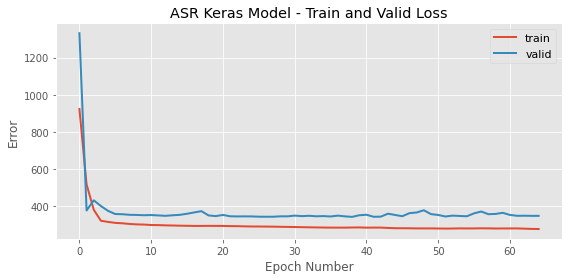

In [46]:
#Train loss plot
fig = plt.figure(figsize=(8, 4))
loss_df = pd.read_csv(train_loss_plot_path)
plt.plot(loss_df.train, linewidth=2, label="train")
plt.plot(loss_df.valid, linewidth=2, label="valid")
plt.title("ASR Keras Model - Train and Valid Loss")
plt.xlabel("Epoch Number",  fontsize=12)
plt.ylabel("Error",  fontsize=12)
plt.legend(loc="best", fontsize=11)
fig.tight_layout() # This minimises whitespace around the axes.
plt.savefig(os.path.join(model_folder_path,"loss_plot.pdf"))

In [8]:
#Generate spectogram
def get_spectogram(audio, frame_length, frame_step, fft_length):
    spectrogram = tf.signal.stft(
        audio, frame_length=frame_length, frame_step=frame_step, fft_length=fft_length
    )
    # 5. We only need the magnitude, which can be derived by applying tf.abs
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.math.pow(spectrogram, 0.5)
    # 6. normalisation
    means = tf.math.reduce_mean(spectrogram, 1, keepdims=True)
    stddevs = tf.math.reduce_std(spectrogram, 1, keepdims=True)
    spectrogram = (spectrogram - means) / (stddevs + 1e-10)
    return spectrogram
    
    

In [ ]:
for batch in train:
    spectrogram = batch[0][0].numpy()
    spectrogram = np.array([np.trim_zeros(x) for x in np.transpose(spectrogram)])
    label = batch[1][0]
    # Spectrogram
    label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
    ax = plt.subplot(2, 1, 1)
    ax.imshow(spectrogram, vmax=1)
    ax.set_title(label)
    ax.axis("off")
    # Wav
    file = tf.io.read_file(wav_path + list(df_train["TED_Talk_ID"])[0] + ".wav")
    audio, _ = tf.audio.decode_wav(file)
    audio = audio.numpy()
    ax = plt.subplot(2, 1, 2)
    plt.plot(audio)
    ax.set_title("Signal Wave")
    ax.set_xlim(0, len(audio))
    display.display(display.Audio(np.transpose(audio), rate=16000))
plt.show()

In [16]:
"BECAUSE|OF"

'BECAUSE|OF'